In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# auto reload the objects
%load_ext autoreload
%autoreload 2
import re
import pandas as pd
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
import numpy as np
import os
#os.getcwd()
# enable interactive plotly in notebook
import plotly.express as px
#from plotly.offline import init_notebook_mode
#init_notebook_mode(connected = True)
import sklearn.datasets
from scipy.stats import stats
import requests
import pandas as pd
#!pip install umap-learn
import umap as UMAP
import numpy as np
#from google.colab import drive
#drive.mount('/content/drive/')
#!pip install numba==0.55.2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
inputdir = "/home/zongliang/Terrain/Demo/o-miner"
clinical_clean = pd.read_csv(inputdir+"/output/TCGA_142_clinical_May6.txt",sep="\t")
clinical_clean.head()
transcriptome = pd.read_csv(inputdir+"/output/transcriptome.txt",sep="\t",index_col=0)
transcriptome.head()
candidate = pd.read_csv(inputdir+"/output/candidates_911.txt",sep="\t")
candidate.head()

,PATIENT_ID,SAMPLE_ID,Gene_Expression_Subtype,G-CIMP_Methylation,IDH1_Mutation,...,DSS,PFI.time,PFI,DFS.time,DFS
0,TCGA-02-2485,TCGA-02-2485-01,Classical,non-G-CIMP,WT,...,0.0,186.0,1,186.05,1
1,TCGA-02-2486,TCGA-02-2486-01,Mesenchymal,non-G-CIMP,WT,...,1.0,618.0,1,494.10,0
2,TCGA-06-1804,TCGA-06-1804-01,Classical,non-G-CIMP,WT,...,1.0,414.0,1,414.80,0
3,TCGA-06-2557,TCGA-06-2557-01,Mesenchymal,non-G-CIMP,WT,...,1.0,33.0,1,33.55,0
4,TCGA-06-2558,TCGA-06-2558-01,Proneural,non-G-CIMP,WT,...,NaN,380.0,0,381.25,0


,UBE2Q2P2,HMGB1P1,RNU12-2P,SSX9P,EZHIP,...,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-02-0047-01,-0.3974,-0.0826,-2.0708,NaN,0.4351,...,-0.8546,0.4807,-0.9953,0.8076,-0.3677
TCGA-02-0055-01,1.0246,-1.8728,-0.7532,NaN,-2.1438,...,0.8150,-0.7129,1.0233,-1.1520,0.3233
TCGA-02-2483-01,0.8181,0.2359,-2.0708,NaN,-1.0198,...,3.3626,0.4862,-0.4944,-0.4085,0.2522
TCGA-02-2485-01,0.9404,1.6038,1.0860,NaN,-0.1857,...,-1.4604,-0.0589,-0.4856,0.3293,0.2242
TCGA-02-2486-01,-0.9364,0.3519,-2.0708,NaN,-0.6798,...,-1.4604,-2.0233,0.3060,-1.0706,-0.9038


,gene symbol
0,DLX6
1,NAB2
2,FBP1
3,TLX1
4,H3F3A


In [43]:
mtx_type_pd = transcriptome.merge(clinical_clean[['SAMPLE_ID','Gene_Expression_Subtype','vital_status','DSS.time']],left_index=True, right_on = "SAMPLE_ID", how = "left")
mtx_type_pd = mtx_type_pd[mtx_type_pd.columns[-4:].append(mtx_type_pd.columns[mtx_type_pd.columns.isin(list(candidate['gene symbol']))])]
mtx_type_pd = mtx_type_pd[~pd.isna(mtx_type_pd['Gene_Expression_Subtype'])]
mtx_type_pd = mtx_type_pd[mtx_type_pd.Gene_Expression_Subtype!='Neural']
mtx_type_pd = mtx_type_pd.reset_index(drop=True)

In [84]:
#!pip install workqueue
from scipy.stats import zscore
import scipy
def INHD(pd_3d,colname,**kwargs):
    INHD = []
    names = []
    array_size = [0,1,2] if 'dimension' in kwargs.keys() and kwargs['dimension'].upper() == '3D' else [0,1]
    for moltype in pd_3d.type.unique():
        pd_3d_sel = pd_3d.loc[pd_3d.type.isin([moltype]),:]
        INHD.append(np.mean(
            scipy.spatial.distance.pdist(
                np.array(pd_3d_sel[array_size]), metric='sqeuclidean'
            )
        )/np.mean(
            scipy.spatial.distance.pdist(
                np.array(pd_3d[array_size]), metric='sqeuclidean'
            )
        ))
        names.append(moltype)
    INHD = pd.DataFrame(INHD)
    INHD.index = names
    INHD.columns = [colname]
    return(INHD)
###############
### densmap ###
###############
#py.init_notebook_mode()
#!pip install densmap-learn
from bokeh.palettes import Category10_4, Category20, Category20b, Category20c
color_discrete_map1={
    "Classical": Category10_4[0],
    "Mesenchymal": Category10_4[1],
    #"Neural": Category10_4[1],
    "Proneural": Category10_4[2]
}



def plot_scatter(proj_2d,**kwargs):
    label = kwargs['label'] if 'label' in kwargs.keys() else 'densmap'
    itm = kwargs['itm'] if 'itm' in kwargs.keys() else 'Gene_Expression_Subtype'
    continuous = kwargs['continuous'] if 'continuous' in kwargs.keys() else 'No' 
    list_type = []   
    for moltype in mtx_type_pd[itm]:
        if moltype not in list_type:
            list_type.append(moltype)
    if continuous == 'No':
        fig_2d = px.scatter(
            proj_2d, x=0, y=1,
            color_discrete_sequence= list([color_discrete_map1[j] for j in list_type]),#["red", "green", "blue", "goldenrod"], #, "magenta"
            color=mtx_type_pd[itm], labels={'color': 'Type'},
            hover_name = mtx_type_pd["SAMPLE_ID"],
            width=800, height=600
        )
    else:
        fig_2d = px.scatter(
            proj_2d, x=0, y=1,
            color_continuous_scale='viridis',
            color=np.log(mtx_type_pd[itm])/np.log(10), labels={'color': 'log(DSS.time)'},
            hover_name = mtx_type_pd["SAMPLE_ID"],
            width=800, height=600
        )
        
    fig_2d.update_xaxes(title = label+"1")
    fig_2d.update_yaxes(title = label+"2")
    fig_2d.show(marker_size=5)
    
from umap import UMAP
itm = 'Gene_Expression_Subtype'
# densmap_2d = densmap.densMAP(n_components=2,dens_frac=0.3,dens_lambda=0.1,random_state=0,
                          # var_shift = 0.1,n_neighbors=30,metric = "euclidean", 
                          # n_epochs=750, learning_rate = 1,
                          # min_dist = 0.1,spread = 1,set_op_mix_ratio = 1,
                          # local_connectivity = 1,repulsion_strength = 1,negative_sample_rate = 5,
                          # transform_queue_size = 4,target_n_neighbors = -1,target_weight = 0.5) # init='random',n_components=2,n_components=2, 
map_2d = UMAP(n_components=2,  random_state=0) #init='random',

embedding = mtx_type_pd.iloc[:,4:]
weight = 22
marker_2d_INHD = pd.DataFrame()
for weight in range(15,23):
    embedding['clinical'] = mtx_type_pd[['DSS.time']].apply(zscore)*weight
    proj_2d = map_2d.fit_transform(embedding)
    
    # 2D expression in-network distance
    pd_2d_gene = pd.DataFrame(proj_2d)
    pd_2d_gene['type'] = mtx_type_pd[[itm]].reset_index(drop=True)
    exp_2d_INHD = INHD(pd_2d_gene,'umap')
    
    # the survival related in network distance
    DSStime = mtx_type_pd[['DSS.time']]
    DSStime_label = mtx_type_pd[['DSS.time']]
    p25 = np.percentile(DSStime, 25)
    p75 = np.percentile(DSStime, 75)
    DSStime_label[DSStime < p25] = 'low'
    DSStime_label[DSStime > p75] = 'high'
    DSStime_label[(DSStime<=p75) &(DSStime>=p25)] = 'intermedian'
    
    
    pd_2d_gene = pd.DataFrame(proj_2d)
    pd_2d_gene['type'] = DSStime_label
    exp_2d_INHD_survival = INHD(pd_2d_gene,'umap')
    
    exp_2d_INHD=exp_2d_INHD.append(exp_2d_INHD_survival)
    exp_2d_INHD['weight'] = weight
    marker_2d_INHD = marker_2d_INHD.append(exp_2d_INHD)

<ipython-input-84-5f541b4df120>:95: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-84-5f541b4df120>:95: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-84-5f541b4df120>:96: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-84-5f541b4df120>:96: SettingWithCopyWarning:


A value is trying

<ipython-input-84-5f541b4df120>:95: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-84-5f541b4df120>:95: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-84-5f541b4df120>:96: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-84-5f541b4df120>:96: SettingWithCopyWarning:


A value is trying

In [85]:
marker_2d_INHD.groupby("weight").sum()

,umap
weight,
15,4.188312
16,4.012800
17,4.094075
18,4.083828
19,3.875761
20,3.915492
21,3.947077
22,3.884675


In [87]:

embedding = mtx_type_pd.iloc[:,4:]
weight = 19
embedding['clinical'] = mtx_type_pd[['DSS.time']].apply(zscore)*weight
proj_2d = map_2d.fit_transform(embedding)

plot_scatter(proj_2d,label='umap',itm='Gene_Expression_Subtype',continuous='No')
plot_scatter(proj_2d,label='umap',itm='DSS.time',continuous='Yes')

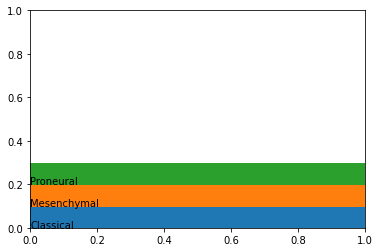

Loading BokehJS ...

    'data': [{'hoverinfo': 'text',
              'marker': {'color': [#2ca02c, #…

In [15]:
mtx_type_pd['V1'] = proj_2d[:,0]
mtx_type_pd['V2'] = proj_2d[:,1]
mtx_type_pd['sampleID'] = mtx_type_pd['SAMPLE_ID']
##################
### color test ###
##################
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import math

def test_color(color_discrete_map1):
    fig = plt.figure()
    ax = fig.add_subplot(111)   
    color = color_discrete_map1.values() #colors.cnames
    #print(len(color))
    ratio = 1.0 / 5.0
    count = math.ceil(math.sqrt(len(color)))
    x_count = count * ratio
    y_count = count / ratio
    x = 0
    y = 0
    w = 1 / x_count
    h = 1 / y_count    
    for cl_idx in range(0,len(color)):
        cl = list(color)[cl_idx]
        label = list(color_discrete_map1.keys())[cl_idx]
        #print(cl)
        pos = (x / x_count, y / y_count)
        ax.add_patch(patches.Rectangle(pos, w, h, color=cl))
        #ax.annotate(cl, xy=pos)
        ax.annotate(label, xy=pos)
        if y >= y_count-1:
            x += 1
            y = 0
        else:
            y += 1
    plt.show()
test_color(color_discrete_map1)   
##############################
# 2.2. select the subcohorts #
# https://plotly.com/python/v3/selection-events/ #
import plotly.graph_objs as go
import plotly.offline as py

import pandas as pd
import numpy as np
from ipywidgets import interactive, HBox, VBox, Layout

#from google.colab import output
#output.enable_custom_widget_manager()

#py.init_notebook_mode(connected=True)
df = mtx_type_pd
f = go.FigureWidget([
    go.Scatter(y = df['V2'], x = df['V1'], mode = 'markers',
        text = df['sampleID'],
        hoverinfo = 'text',
        marker_color = [color_discrete_map1[j] for j in df[itm]]
    )
])
scatter = f.data[0]
scatter.x = scatter.x# + np.random.rand(N)/10 *(df['City mpg'].max() - df['City mpg'].min())
scatter.y = scatter.y# + np.random.rand(N)/10 *(df['City mpg'].max() - df['City mpg'].min())
scatter.marker.opacity = 1
f.layout.xaxis.title = 'UMAP_x'
f.layout.yaxis.title = 'UMAP_y'


def update_axes(xaxis, yaxis):
    scatter = f.data[0]
    scatter.x = df[xaxis]
    scatter.y = df[yaxis]
    #with f.batch_update():
    #    f.layout.xaxis.title = xaxis
    #    f.layout.yaxis.title = yaxis
        #scatter.x = scatter.x + np.random.rand(N)/10 *(df[xaxis].max() - df[xaxis].min())
        #scatter.y = scatter.y + np.random.rand(N)/10 *(df[yaxis].max() - df[yaxis].min())

axis_dropdowns = interactive(
    update_axes, yaxis = df.select_dtypes('int64').columns, 
    xaxis = df.select_dtypes('int64').columns
)

# Create a table FigureWidget that updates on selection from points in the scatter plot of f
t = go.FigureWidget([go.Table(
    header=dict(
        values=['sampleID',itm],fill = dict(color='#C2D4FF'),align = ['left'] * 5),
    cells=dict(
        values=[df[col] for col in ['sampleID',itm]],
        fill = dict(color='#F5F8FF'),align = ['left'] * 5))])

def selection_fn(trace,points,selector):
    t.data[0].cells.values = [df.loc[points.point_inds][col] for col in ['sampleID',itm]]


scatter.on_selection(selection_fn)

# Put everything together
from bokeh.io import output_notebook 
output_notebook()
# ref: https://github.com/googlecolab/colabtools/issues/498
#VBox((HBox(axis_dropdowns.children),f,t))
VBox((f,t),layout=Layout(height='900px', width='500px'))


In [94]:
#Glblhig = pd.DataFrame(t.data[0].cells.values).T
#Glblhig.columns = ['sampleID','Type']
#Glbllow = pd.DataFrame(t.data[0].cells.values).T
#Glbllow.columns = ['sampleID','Type']
#Mhigh = pd.DataFrame(t.data[0].cells.values).T
#Mhigh.columns = ['sampleID','Type']
#Mlow = pd.DataFrame(t.data[0].cells.values).T
#Mlow.columns = ['sampleID','Type']
#Phigh = pd.DataFrame(t.data[0].cells.values).T
#Phigh.columns = ['sampleID','Type']
#Plow = pd.DataFrame(t.data[0].cells.values).T
#Plow.columns = ['sampleID','Type']
#Chigh = pd.DataFrame(t.data[0].cells.values).T
#Chigh.columns = ['sampleID','Type']
#Clow = pd.DataFrame(t.data[0].cells.values).T
#Clow.columns = ['sampleID','Type']

In [123]:
len(Mhigh)
len(Mlow)
len(Phigh)
len(Plow)
len(Chigh)
len(Clow)
Mhigh

18

22

13

12

23

11

,sampleID,Type
0,TCGA-02-2486-01,Mesenchymal
1,TCGA-06-0168-01,Mesenchymal
2,TCGA-06-0184-01,Mesenchymal
3,TCGA-06-2561-01,Mesenchymal
4,TCGA-06-2562-01,Mesenchymal
...,...,...
13,TCGA-28-5213-01,Mesenchymal
14,TCGA-32-2615-01,Mesenchymal
15,TCGA-32-2632-01,Mesenchymal
16,TCGA-32-4213-01,Mesenchymal


In [125]:
Mhigh.to_csv(inputdir+"/output/Mhigh.txt",sep="\t",index=None)
Mlow.to_csv(inputdir+"/output/Mlow.txt",sep="\t",index=None)
Phigh.to_csv(inputdir+"/output/Phigh.txt",sep="\t",index=None)
Plow.to_csv(inputdir+"/output/Plow.txt",sep="\t",index=None)
Chigh.to_csv(inputdir+"/output/Chigh.txt",sep="\t",index=None)
Clow.to_csv(inputdir+"/output/Clow.txt",sep="\t",index=None)

In [133]:
########################################################
# 3. generate the DEGs in the comparison of subcohorts #
from scipy.stats import stats
def to_scientific_notation(number):
    try:
        a, b = '{:.4E}'.format(number).split('E')
        return '{:.2f}E{:+03d}'.format(float(a)/10, int(b)+1)
    except:
        return number

def survival_ttest(Chigh,Clow,mtx_type_pd,skip_column):
    group1 = mtx_type_pd[mtx_type_pd.SAMPLE_ID.isin(Chigh.sampleID.values)]
    group2 = mtx_type_pd[mtx_type_pd.SAMPLE_ID.isin(Clow.sampleID.values)]
    scientific = []
    mean1 = []
    mean2 = []
    labels = []
    
    for GeneSymbol in list(group1.columns[~group1.columns.isin(skip_column)].values):
        # Get the p-value
        pvalue = stats.ttest_ind(
            group1.loc[:,group1.columns.values == GeneSymbol].values,
            group2.loc[:,group2.columns.values == GeneSymbol].values
        )[1]
        mean1.append(group1.loc[:,group1.columns.values == GeneSymbol].values.mean())
        mean2.append(group2.loc[:,group2.columns.values == GeneSymbol].values.mean())        
        scientific.append(to_scientific_notation(pvalue[0]))
        if pvalue >= 0.05:
            label = 'ns' 
        elif pvalue >= 0.01: 
            label = '* ' 
        elif pvalue >= 0.001:
            label = '** '
        else:
            label = '*** '
        labels.append(label)
    p_table=pd.DataFrame({
        "symbol":group1.columns[~group1.columns.isin(skip_column)].values,
        "Grp.1 mean":mean1,
        "Grp.2 mean":mean2,
        "logFC": np.array(mean1)-np.array(mean2),
        "p-value":scientific,
        "label":labels
    })
    p_table['score'] = [np.float(i) for i in scientific]
    p_table=p_table.sort_values(by=['score'])
    p_table=p_table[["symbol","Grp.1 mean","Grp.2 mean","logFC","p-value","label"]]
    return p_table

In [134]:
mtx_type_pd

,SAMPLE_ID,Gene_Expression_Subtype,vital_status,DSS.time,ABCA6,...,ZNF384,ZNF521,ZNF560,ZNF695,ZRSR2
0,TCGA-02-0047-01,Proneural,Dead,448.0,0.6853,...,-1.0165,-0.5599,0.5847,0.5233,-1.1243
1,TCGA-02-0055-01,Mesenchymal,Dead,76.0,0.8023,...,-1.1584,-0.7806,0.7610,1.1806,1.4716
2,TCGA-02-2485-01,Classical,Alive,470.0,-0.5379,...,1.0085,0.7577,-0.1330,-1.1050,-0.2762
3,TCGA-02-2486-01,Mesenchymal,Dead,618.0,0.6180,...,-0.9980,-1.1557,-1.1161,-0.7956,1.1523
4,TCGA-06-0125-01,Classical,Dead,1448.0,-0.0689,...,0.7755,0.7257,-0.0062,-0.7387,1.3021
...,...,...,...,...,...,...,...,...,...,...,...
111,TCGA-76-4925-01,Proneural,Dead,146.0,-1.2294,...,0.6245,0.5288,-0.7286,-0.8318,-0.0458
112,TCGA-76-4926-01,Classical,Dead,138.0,2.0147,...,-0.6271,1.1673,-0.5649,0.7975,-0.3860
113,TCGA-76-4928-01,Classical,Dead,94.0,2.2640,...,-0.3066,-0.7741,-0.3092,-0.9639,1.3553
114,TCGA-76-4931-01,Classical,Dead,279.0,-1.2790,...,1.1987,0.2250,0.5839,-0.9266,1.1906


In [135]:
m_p_table = survival_ttest(Mhigh,Mlow,mtx_type_pd,['SAMPLE_ID','Gene_Expression_Subtype','vital_status','DSS.time'])
p_p_table = survival_ttest(Phigh,Plow,mtx_type_pd,['SAMPLE_ID','Gene_Expression_Subtype','vital_status','DSS.time'])
c_p_table = survival_ttest(Chigh,Clow,mtx_type_pd,['SAMPLE_ID','Gene_Expression_Subtype','vital_status','DSS.time'])

<ipython-input-133-4c76dc97dcdf>:21: DeprecationWarning:

Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.

<ipython-input-133-4c76dc97dcdf>:45: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-133-4c76dc97dcdf>:21: DeprecationWarning:

Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.

<ipython-input-133-4c76dc97dcdf>:45: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy sca

In [136]:
m_p_table.to_csv(inputdir+"/output/Mhigh_vs_low_transcriptome.txt",sep="\t",index=None)
p_p_table.to_csv(inputdir+"/output/Phigh_vs_low_transcriptome.txt",sep="\t",index=None)
c_p_table.to_csv(inputdir+"/output/Chigh_vs_low_transcriptome.txt",sep="\t",index=None)

In [137]:
m_p_table['p-value'] = [np.float(i) for i in m_p_table['p-value']]
p_p_table['p-value'] = [np.float(i) for i in p_p_table['p-value']]
c_p_table['p-value'] = [np.float(i) for i in c_p_table['p-value']]
m_p_table[m_p_table['p-value']<=0.05]
p_p_table[p_p_table['p-value']<=0.05]
c_p_table[c_p_table['p-value']<=0.05]

<ipython-input-137-03d62f55369a>:1: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-137-03d62f55369a>:2: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-137-03d62f55369a>:3: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this wi

,symbol,Grp.1 mean,Grp.2 mean,logFC,p-value,label
129,CDKN1B,0.120339,-1.067745,1.188084,0.00012,***
469,MUTYH,0.488717,-0.563736,1.052453,0.00039,***
753,TPM4,-0.036400,1.000268,-1.036668,0.00051,***
308,GDF15,0.045544,0.893086,-0.847542,0.00073,***
94,CARS,-0.349822,0.499700,-0.849522,0.00090,***
...,...,...,...,...,...,...
241,ETV5,-0.336856,0.174509,-0.511365,0.04700,*
55,BBOX1,0.416244,-0.190482,0.606726,0.04800,*
274,FGFBP2,-0.445661,0.260377,-0.706038,0.04800,*
189,DAZ1,-0.463744,-0.640891,0.177146,0.04900,*


,symbol,Grp.1 mean,Grp.2 mean,logFC,p-value,label
113,CD177,-0.653977,-1.113525,0.459548,0.0017,**
392,KDM6A,0.242962,-0.588025,0.830987,0.0058,**
275,FGFR1,-0.600185,0.266725,-0.866910,0.0060,**
94,CARS,-0.615446,0.421717,-1.037163,0.0061,**
468,MUC1,-0.980254,-0.201167,-0.779087,0.0091,**
...,...,...,...,...,...,...
194,DCTN2,1.349008,-0.044192,1.393199,0.0470,*
693,SPOP,0.399677,-0.294600,0.694277,0.0470,*
602,PWWP2A,0.045100,0.616750,-0.571650,0.0480,*
401,KLHDC7A,-1.086477,-0.667875,-0.418602,0.0490,*


,symbol,Grp.1 mean,Grp.2 mean,logFC,p-value,label
572,PNMA5,-0.900326,0.179845,-1.080172e+00,0.00077,***
337,HGF,-0.958326,0.182273,-1.140599e+00,0.00120,**
442,MET,-0.901991,0.104655,-1.006646e+00,0.00290,**
526,OR4K2,-1.760400,-1.760400,4.440892e-16,0.00300,**
190,DAZ4,-3.021700,-3.021700,-4.440892e-16,0.00300,**
...,...,...,...,...,...,...
801,ZNF521,0.744804,0.372909,3.718953e-01,0.04700,*
568,PLCG1,0.887896,0.366827,5.210684e-01,0.04800,*
112,CD14,-0.773170,-0.249418,-5.237514e-01,0.04900,*
448,MLF1,-0.438813,0.066382,-5.051949e-01,0.05000,*


In [138]:
import sys
sys.path.append('/home/zongliang/PAGER/script')
import PAGER as pager
PAGER = pager.PAGER()

In [182]:
m_path = PAGER.run_pager(
    list(m_p_table[m_p_table['p-value']<=0.05].symbol),
    source = ['KEGG_2021_HUMAN', 'WikiPathway_2021', 'BioCarta', 'Reactome_2021', 'Spike'],
    Type='All',
    minSize=1,
    maxSize=2000,
    similarity = 0.05,
    overlap = 1,
    nCoCo = 0,
    pValue = 0.05,
    FDR = 0.05
)
p_path = PAGER.run_pager(
    list(p_p_table[p_p_table['p-value']<=0.05].symbol),
    source = ['KEGG_2021_HUMAN', 'WikiPathway_2021', 'BioCarta', 'Reactome_2021', 'Spike'],
    Type='All',
    minSize=1,
    maxSize=2000,
    similarity = 0.05,
    overlap = 1,
    nCoCo = 0,
    pValue = 0.05,
    FDR = 0.05
)
c_path = PAGER.run_pager(
    list(c_p_table[c_p_table['p-value']<=0.05].symbol),
    source = ['KEGG_2021_HUMAN', 'WikiPathway_2021', 'BioCarta', 'Reactome_2021', 'Spike'],
    Type='All',
    minSize=1,
    maxSize=2000,
    similarity = 0.05,
    overlap = 1,
    nCoCo = 0,
    pValue = 0.05,
    FDR = 0.05
)

In [183]:
### add mean value to pathways ###
m_logFCtable = m_p_table[m_p_table['p-value']<=0.05][['symbol','logFC']]
p_logFCtable = p_p_table[p_p_table['p-value']<=0.05][['symbol','logFC']]
c_logFCtable = c_p_table[c_p_table['p-value']<=0.05][['symbol','logFC']]
def add_mean(m_path,m_logFCtable):
    M_path_gene = PAGER.pathMember(m_path.GS_ID)

    meanTable = M_path_gene.merge(
        m_logFCtable,
        left_on = "GENE_SYM",right_on = "symbol").groupby(['GS_ID'])['logFC'].mean().reset_index()
    meanTable.columns = ['GS_ID',"MEAN"]

    m_path = m_path.merge(meanTable,left_on = "GS_ID",right_on ="GS_ID")
    return(m_path)

m_path = add_mean(m_path,m_logFCtable)
p_path = add_mean(p_path,p_logFCtable)
c_path = add_mean(c_path,c_logFCtable)

In [343]:
m_path

,GS_ID,NAME,SOURCE,GS_SIZE,ORGANISM,...,SIMILARITY_SCORE,pvalue,Rank,pFDR,MEAN
0,WIG001833,Hearing and Vision Proteins,Spike,370,Homo sapiens,...,.0599409754582168375271823547685616651134,7.032977e-17,1,3.769676e-14,0.073328
1,WAG001778,hsa04151 PI3K-Akt signaling pathway - Homo sap...,KEGG_2021_HUMAN,354,Homo sapiens,...,.0573366239290515459780493188065571139068,7.828309e-16,2,4.188145e-13,-0.144144
2,WAG001946,hsa05215 Prostate cancer - Homo sapiens (human),KEGG_2021_HUMAN,97,Homo sapiens,...,.0673504631325553404155110157517400177926,1.211218e-15,3,6.467904e-13,-0.246644
3,WAG001933,hsa05200 Pathways in cancer - Homo sapiens (hu...,KEGG_2021_HUMAN,531,Homo sapiens,...,.0523906306306306306306306306306306306306,2.593014e-14,4,1.382076e-11,-0.074324
4,WAG001938,hsa05206 MicroRNAs in cancer - Homo sapiens (h...,KEGG_2021_HUMAN,310,Homo sapiens,...,.0527436527436527436527436527436527436527,5.563874e-14,5,2.959981e-11,-0.171718
...,...,...,...,...,...,...,...,...,...,...,...
47,WAG014661,Activated MAPKs phosphorylate MAP2K1,Reactome_2021,4,Homo sapiens,...,.057017543859649122807017543859649122807,9.955902e-03,441,4.977951e-02,-0.715979
48,WAG014674,MAP2K mutants constitutively phosphorylate MAPKs,Reactome_2021,4,Homo sapiens,...,.057017543859649122807017543859649122807,9.955902e-03,441,3.982361e-02,-0.715979
49,WAG015048,"CCND3,(CCND1,CCND2) binds RUNX1",Reactome_2021,4,Homo sapiens,...,.057017543859649122807017543859649122807,9.955902e-03,441,2.986771e-02,-0.613769
50,WAG016066,Tankyrase ADP-ribosylates AXIN,Reactome_2021,4,Homo sapiens,...,.057017543859649122807017543859649122807,9.955902e-03,441,1.991180e-02,0.880059


In [195]:
RES = pd.DataFrame()
Msurv = m_path[['GS_ID','MEAN','NAME','pFDR','SIMILARITY_SCORE','SOURCE']]
Msurv['TYPE'] = 'Mesenchymal'
Psurv = p_path[['GS_ID','MEAN','NAME','pFDR','SIMILARITY_SCORE','SOURCE']]
Psurv['TYPE'] = 'Proneural'
Csurv = c_path[['GS_ID','MEAN','NAME','pFDR','SIMILARITY_SCORE','SOURCE']]
Csurv['TYPE'] = 'Classical'
RES = RES.append(Msurv)
RES = RES.append(Psurv)
RES = RES.append(Csurv)
RES = RES.rename(columns = {'GS_ID':'ID','pFDR':'FDR'})
RES = RES.reset_index(drop=True)

<ipython-input-195-40122f5f44a1>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-195-40122f5f44a1>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-195-40122f5f44a1>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-195-401

In [201]:
#####################################################
# compare functional groups in the enriched PAGs #
color_discrete_map2={
    "Global_survive_high_vs_low": Category10_4[3],
    "Classical_survive_high_vs_low": Category10_4[0],
    "Mesenchymal_survive_high_vs_low": Category10_4[1],  
    "Proneural_survive_high_vs_low": Category10_4[2]
}
wei={
    "Classical_survive_high_vs_low": 0.2,
    "Mesenchymal_survive_high_vs_low": 0.4,
    "Global_survive_high_vs_low": 0,
    "Proneural_survive_high_vs_low": 0.6
}
color_discrete_map2={
    "Global": Category10_4[3],
    "Classical": Category10_4[0],
    "Mesenchymal": Category10_4[1],  
    "Proneural": Category10_4[2]
}
wei={
    "Classical": 0.2,
    "Mesenchymal": 0.4,
    "Global": 0,
    "Proneural": 0.6
}
import plotly.graph_objects as go
def enrich_scatter(RES,**kwargs):
    labelOrder= kwargs['labelOrder'] if 'labelOrder' in kwargs.keys() else [0,3,2,1]
    fig = go.Figure()
    for i in np.unique(RES['TYPE']):
        RES.loc[RES['TYPE'].isin([i]),i] = RES.loc[RES['TYPE'].isin([i]),'MEAN']
        RES.loc[RES['TYPE'].isin([i]),i+'FDR'] = RES.loc[RES['TYPE'].isin([i]),'FDR']
    
    xlabel = kwargs['xlabel'] if 'xlabel' in kwargs.keys() else 'ID'
    #RES = RES.sort_values('FDR')
    arrays = []
    arrays = [
        list(RES[xlabel].values),
        [i[0-3] for i in list(RES['TYPE'].values)]#list(RES['TYPE'].values)    
    ]
    
    tuples = list(zip(*arrays))
    xlabels= [list(RES[xlabel].values),
              [i[0:3] for i in list(RES['TYPE'].values)],#list(RES['TYPE'].values),
              tuples]
    #print(xlabels)
    for sample in np.unique(RES['TYPE']):#for idx, tec in enumerate(df.columns[2:4]):    

        fig.add_trace(
            go.Bar(
                x=xlabels,
                y=RES[sample],
                name=sample,
                marker_color=color_discrete_map2[sample],
                width=0.1,
                showlegend=False,
            )
        )
        #fig.add_trace(
        #    go.Bar(
        #        x = xlabels,
        #        base = min(RES['MEAN'])-1.1 *abs(min(RES['MEAN'])),
        #        y = RES[sample]/RES[sample] + min(RES['MEAN']),#-wei[sample],
        #        name=sample,
        #        marker_color=color_discrete_map2[sample],
        #        width=1,
        #        showlegend=False,
        #        #connectgaps=True
        #    )
        #)
        fig.add_trace(
            go.Scatter(
                x=xlabels,
                y=RES[sample],
                name=sample,
                mode='markers',
                marker_color=color_discrete_map2[sample],
                text=RES["NAME"],
                #width=0.7,
                marker=dict(
                    size=[-np.log(j)/np.log(10)+3 for j in RES['FDR']]
                    #size=[-np.log(j)/2 for j in RES[RES.TYPE == sample]['FDR']],                
                    #showscale=True
                )
            )
        )
    fig.update_layout(
        yaxis=dict(
            titlefont_size=16,
            tickfont_size=12,
            title="Expression",
            #showspikes=True
            categoryorder='array', categoryarray= list(np.unique(RES['TYPE'])[labelOrder])
        ),
        xaxis=dict(
            titlefont_size=16,
            tickfont_size=12,
            title="Pathway",
            #type ='category',
            categoryorder='array', categoryarray= list(np.unique(RES['TYPE'])[labelOrder])
        ),
        title_text='',
        template='plotly_white',
        barmode='stack',
        #width = 30*n
    )

    return fig

In [206]:
fig = enrich_scatter(RES,labelOrder=[2,1,0])
#select_IDs=pd.DataFrame(t.data[0].cells.values).T[0].values
#fig = enrich_scatter(RES[RES.ID.isin(select_IDs)])
fig.show()

,ID
TYPE,
Classical,99
Mesenchymal,40
"Mesenchymal,Classical",2
"Mesenchymal,Proneural",10
Proneural,20


<Figure size 144x288 with 0 Axes>

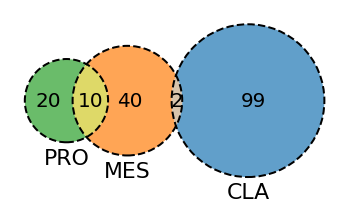

<Figure size 144x288 with 0 Axes>

In [209]:
# pathway overlap
#RES_G = RES[RES.ID.isin(RES[RES.TYPE=='Global']['ID'])]
RES_G = RES
aggretype=RES_G[['ID','TYPE']].groupby(['ID'], as_index = False).agg({'TYPE': ','.join})
count_venn=aggretype.groupby(['TYPE']).count()
count_venn
# import module
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
sets = (40, 20, 10, 99, 2, 0, 0)
# depict venn diagram
v_test1 = venn3(subsets=sets, 
      set_labels=('MES', 'PRO', 'CLA'), 
      set_colors=[color_discrete_map2[sample] for sample in ['Mesenchymal', 'Proneural', 'Classical']], 
      alpha=0.7
     )
for t in v_test1.set_labels: t.set_fontsize(22)
for t in v_test1.subset_labels: 
    if t != None: t.set_fontsize(20) 
# outline of circle line style and width
venn3_circles(subsets=sets,
              linestyle="dashed", linewidth=2)
  
# title of the venn diagram
#plt.title("Venn diagram of three subcohorts of survival high vs low")
plt.figure(figsize=(2, 4))
plt.show()

In [215]:
RES.NAME = [re.sub(" - Homo sapiens \(human\)","",i) for i in RES.NAME]
import matplotlib
def enrich_scatter_two(RES,order,**kwargs):
    
    exclude = kwargs['exclude'] if 'exclude' in kwargs.keys() else []
    width = kwargs['width'] if 'width' in kwargs.keys() else 800
    height = kwargs['height'] if 'height' in kwargs.keys() else 800
    
    for i in np.unique(RES['TYPE']):
        RES.loc[RES['TYPE'].isin([i]),i] = RES.loc[RES['TYPE'].isin([i]),'MEAN']
        RES.loc[RES['TYPE'].isin([i]),i+'FDR'] = RES.loc[RES['TYPE'].isin([i]),'FDR']
        
    RES = RES.sort_values('FDR',ascending = False)
    RES_refine = RES[~RES['TYPE'].isin(exclude)]
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=RES_refine['TYPE'],
            y=RES_refine['NAME'],
            #name=sample,
            mode='markers',
            marker_color=RES_refine['MEAN'],#[color_discrete_map2[i] for i in RES['TYPE']],
            text=RES_refine["ID"],
            #width=0.7,
            marker=dict(
                size=[-np.log(j)/np.log(10)+5 for j in RES_refine['FDR']],
                showscale=True,
                colorscale='RdBu_r',
                cmax = 1.5,
                cmin = -1.5,
            ),
            
        )
    )
    xtickfont_size = kwargs['xtickfont_size'] if "xtickfont_size" in kwargs.keys() else 12
    ytickfont_size = kwargs['ytickfont_size'] if "ytickfont_size" in kwargs.keys() else 12
    fig.update_layout(
        xaxis=dict(
            titlefont_size=16,
            tickfont_size=xtickfont_size,
            title="",
            categoryorder='array', categoryarray= list(np.unique(RES_refine['TYPE'])[order])
            #showspikes=True
        ),
        yaxis=dict(
            titlefont_size=16,
            tickfont_size=ytickfont_size,
            #type ='category',
        ),
        title_text='',
        template='plotly_white',
        barmode='stack',
        #width = 30*n
        width = width,
        height = height
    )

    return fig

#select_IDs=pd.DataFrame(t.data[0].cells.values).T[0].values
#fig = enrich_scatter_two(RES[RES.ID.isin(select_IDs)])
fig = enrich_scatter_two(RES,[1,2,0],width = 800,height = 1200,
                         xtickfont_size=15,ytickfont_size=10,
                         exclude = ['Global'])
fig.show()

In [217]:
M_P_C = RES_G.groupby(['ID'])['SOURCE'].count()[RES_G.groupby(['ID'])['SOURCE'].count() == 3]
two = RES_G.groupby(['ID'])['SOURCE'].count()[RES_G.groupby(['ID'])['SOURCE'].count() == 2]
one = RES_G.groupby(['ID'])['SOURCE'].count()[RES_G.groupby(['ID'])['SOURCE'].count() == 1]
fig = enrich_scatter_two(
    RES[RES.ID.isin(list(list(M_P_C.index)+list(two.index)))],
    [1,2,0],
    height=500,exclude = ['Global']
)
fig.show()
#12

In [218]:
len(np.unique(RES[RES.ID.isin(list(one.index))]['NAME']))
fig = enrich_scatter_two(RES[RES.ID.isin(list(one.index))],[1,2,0],
                         xtickfont_size=15,ytickfont_size=10,
                         height = 1000,width = 800,
                         exclude = ['Global'])
fig.show()

159

In [293]:
unique_name = RES[RES.ID.isin(list(M_P_C.index)+list(two.index))].groupby(['ID','NAME'])['FDR'].count().reset_index()
#unique_name = RES[RES.ID.isin(one.index)].groupby(['ID','NAME'])['FDR'].count().reset_index()
unique_name.NAME.values
#unique_name = all_term_res.groupby(['ID','NAME'])['FDR'].count().reset_index()
#all_term_res.NAME.values
indx = 4
pathwayname = unique_name.NAME[indx]
select_id = unique_name.ID[indx]
select_id
pathwayname
#fig = enrich_scatter(RES[RES.ID.isin([select_id])],xlabel = 'NAME',labelOrder=[1,3,0])
#fig.show()

array(['hsa05200 Pathways in cancer',
       'hsa05202 Transcriptional misregulation in cancer',
       'hsa05215 Prostate cancer',
       'hsa05230 Central carbon metabolism in cancer',
       'Glioblastoma signaling pathways',
       'Imatinib and chronic myeloid leukemia',
       'CDKN1B gene expression is stimulated by FOXO1,FOXO3,FOXO4',
       'MATEs mediate extrusion of xenobiotics',
       'PI3K catalyses the phosphorylation of PIP2 to PIP3 downstream of PDGFRA extracellular domain dimers',
       'PI3-kinase binds to mutant PDGFR receptor',
       'PI3K catalyses the phosphorylation of PIP2 to PIP3 downstream of mutant PDGFR',
       'PI3-kinase binds to PDGFRA extracellular domain dimers'],
      dtype=object)

'WAG002161'

'Glioblastoma signaling pathways'

In [294]:
m_p_table=pd.read_csv(inputdir+"/output/Mhigh_vs_low_transcriptome.txt",sep="\t")
p_p_table=pd.read_csv(inputdir+"/output/Phigh_vs_low_transcriptome.txt",sep="\t")
c_p_table=pd.read_csv(inputdir+"/output/Chigh_vs_low_transcriptome.txt",sep="\t")

In [344]:
c_genes

,symbol,Grp.1 mean,Grp.2 mean,logFC,p-value,label
0,PNMA5,-0.900326,0.179845,-1.080172e+00,0.00077,***
1,HGF,-0.958326,0.182273,-1.140599e+00,0.00120,**
2,MET,-0.901991,0.104655,-1.006646e+00,0.00290,**
3,OR4K2,-1.760400,-1.760400,4.440892e-16,0.00300,**
4,DAZ4,-3.021700,-3.021700,-4.440892e-16,0.00300,**
...,...,...,...,...,...,...
51,ZNF521,0.744804,0.372909,3.718953e-01,0.04700,*
52,PLCG1,0.887896,0.366827,5.210684e-01,0.04800,*
53,CD14,-0.773170,-0.249418,-5.237514e-01,0.04900,*
54,MLF1,-0.438813,0.066382,-5.051949e-01,0.05000,*


In [350]:
sel_mtx_final['status']==1

array(['TCGA-02-2485-01', 'TCGA-06-0158-01', 'TCGA-06-0187-01',
       'TCGA-06-0743-01', 'TCGA-06-0744-01', 'TCGA-06-1804-01',
       'TCGA-06-2563-01', 'TCGA-06-2565-01', 'TCGA-06-5408-01',
       'TCGA-12-3652-01', 'TCGA-12-3653-01', 'TCGA-14-0790-01',
       'TCGA-15-0742-01', 'TCGA-19-2619-01', 'TCGA-26-5132-01',
       'TCGA-27-1835-01', 'TCGA-27-1837-01', 'TCGA-27-2523-01',
       'TCGA-27-2528-01', 'TCGA-28-5220-01', 'TCGA-32-1970-01',
       'TCGA-32-2638-01', 'TCGA-41-2572-01'], dtype=object)

In [367]:
# KM curve
import lifelines
from lifelines.statistics import logrank_test
### function
# 1. selected samples: 2. pagMembers
def df_mtx(c_sel,pagMembers,mtx_type_pd,c_genes,Chigh):
    sel_mtx = mtx_type_pd[mtx_type_pd.SAMPLE_ID.isin(c_sel)]
    sel_mtx_final = sel_mtx[['SAMPLE_ID','Gene_Expression_Subtype','DSS.time','vital_status']]
    #sel_mtx_final['pathwayScore']= sel_mtx.iloc[:,(sel_mtx.columns.isin(pagMembers.GENE_SYM)) & (sel_mtx.columns.isin(c_genes))].T.mean().values
    sel_mtx_final['pathwayScore']= sel_mtx.iloc[:,(sel_mtx.columns.isin(pagMembers.GENE_SYM)) & (sel_mtx.columns.isin(c_genes))].T.sum().values
    gene_panel = sel_mtx.columns[(sel_mtx.columns.isin(pagMembers.GENE_SYM)) & (sel_mtx.columns.isin(c_genes))]
    # alive
    sel_mtx_final['status'] = 0 
    sel_mtx_final.loc[sel_mtx_final.SAMPLE_ID.isin(Chigh.sampleID.values),'status'] = 1
    
    return(sel_mtx_final,gene_panel)

def plot_KM(sel_mtx_final,cutoff,pathwayname,typename,**kwargs):
    m = sel_mtx_final['status']==1
    sign = kwargs['sign'] if 'sign' in kwargs.keys() else 1.0
    #logrank_test   
    ax = plt.subplot(111)
    T = sel_mtx_final['DSS.time']
    E = sel_mtx_final['pathwayScore']
    
    #print(E)
    #print(T[~m])
    #print(T[m])
    results = logrank_test(T[~m],T[m],event_observed_A=E[~m], event_observed_B=E[m])
    p_value = to_scientific_notation(results.p_value)
    #pvalue = stats.ttest_ind(
    #       T[~m],
    #        T[m]
    #    )[1]
    #print(p_value)
    #print(pvalue)
    #p_value =round(p_value,3)
    
    if sign >= 0:
        high_risk_logistic = True
        low_risk_logistic = False
    else:
        high_risk_logistic = False
        low_risk_logistic = True
    kmf = lifelines.KaplanMeierFitter()
    kmf.fit(T[~m], event_observed = E[~m], label = "surv. low(N="+str(E[~m].shape[0])+")")
    kmf.plot_survival_function(ax = ax, at_risk_counts = low_risk_logistic)
    #kmf.survival_function_.index
    #kmf.survival_function_.values.flatten()
    kmf.fit(T[m], event_observed=E[m], label = "surv. high(N="+str(E[m].shape[0])+")")
    kmf.plot_survival_function(ax = ax, at_risk_counts = high_risk_logistic)
    
    plt.title("Survival analysis of "+typename+" gene panels in "+pathwayname)
    plt.text(0, 0, "p-value:"+str(p_value), fontdict=None)
    plt.show()

In [345]:
Mhigh


,sampleID,Type
0,TCGA-02-2486-01,Mesenchymal
1,TCGA-06-0168-01,Mesenchymal
2,TCGA-06-0184-01,Mesenchymal
3,TCGA-06-2561-01,Mesenchymal
4,TCGA-06-2562-01,Mesenchymal
...,...,...
13,TCGA-28-5213-01,Mesenchymal
14,TCGA-32-2615-01,Mesenchymal
15,TCGA-32-2632-01,Mesenchymal
16,TCGA-32-4213-01,Mesenchymal


<ipython-input-367-84413442f9b4>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-367-84413442f9b4>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-1.0

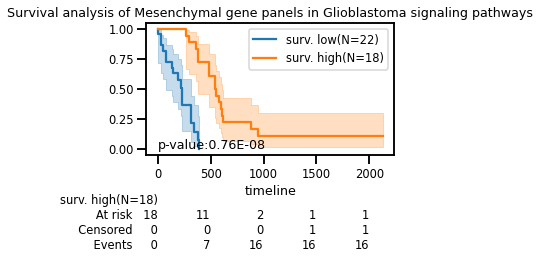

Index(['CDK6', 'CDKN1B', 'EP300', 'ERBB3', 'FGFR1', 'FOXO4', 'MAP2K1', 'PDGFRA', 'PIK3R1'], dtype='object')

<ipython-input-367-84413442f9b4>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-367-84413442f9b4>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1.0

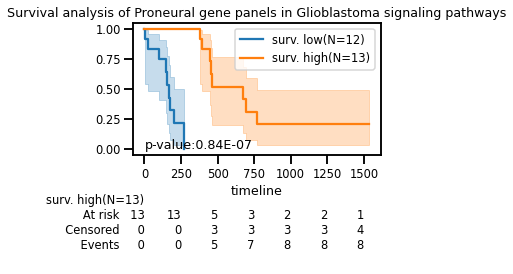

Index(['CDKN1B', 'FGFR1', 'FOXO4', 'PDGFRA', 'TP53'], dtype='object')

<ipython-input-367-84413442f9b4>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-367-84413442f9b4>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-1.0

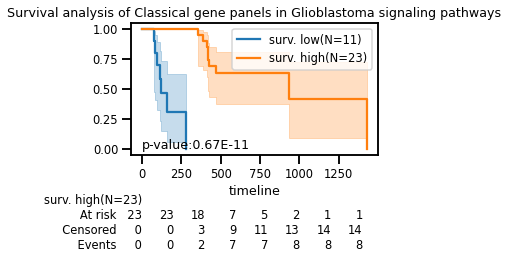

Index(['AKT2', 'MAP2K1', 'MAP2K4', 'MET', 'PLCG1'], dtype='object')

In [368]:

# pathways
pagMembers = PAGER.pathMember([select_id])
geneRanked = PAGER.pagRankedGene(select_id)

# samples
MtopN = Mhigh.shape[0] 
PtopN = Phigh.shape[0] 
CtopN = Chigh.shape[0] 
m_sel_sample = list(Mhigh.sampleID.values) + list(Mlow.sampleID.values)
p_sel_sample = list(Phigh.sampleID.values) + list(Plow.sampleID.values)
c_sel_sample = list(Chigh.sampleID.values) + list(Clow.sampleID.values)
# DEGs
m_p_table["p-value"] = m_p_table["p-value"].astype("double")
p_p_table["p-value"] = p_p_table["p-value"].astype("double")
c_p_table["p-value"] = c_p_table["p-value"].astype("double")
p_cutoff = 2**-4.3
m_genes = m_p_table[(m_p_table["p-value"] < p_cutoff)] #& (np.abs(m_p_table["logFC"])>0.4)]
p_genes = p_p_table[(p_p_table["p-value"] < p_cutoff)] #& (np.abs(p_p_table["logFC"])>1)]
c_genes = c_p_table[(c_p_table["p-value"] < p_cutoff)] #& (np.abs(c_p_table["logFC"])>0.4)]


plt.rcParams["figure.figsize"] = (5,4)
# input selected samples, pathway genes, expression matrix and filtered genes
(Msel_mtx_final,m_gene_panel) = df_mtx(m_sel_sample,pagMembers,mtx_type_pd,m_genes['symbol'],Mhigh)
M_sign=np.sign(Msel_mtx_final[Msel_mtx_final.SAMPLE_ID.isin(Mhigh.sampleID)]['pathwayScore'].sum()-Msel_mtx_final[Msel_mtx_final.SAMPLE_ID.isin(Mlow.sampleID)]['pathwayScore'].sum())
M_sign
plot_KM(Msel_mtx_final,
        Msel_mtx_final['pathwayScore'].mean(),#0,
        pathwayname,"Mesenchymal",#sign=M_sign,
       )
m_gene_panel

(Psel_mtx_final,p_gene_panel) = df_mtx(p_sel_sample,pagMembers,mtx_type_pd,p_genes['symbol'],Phigh)
P_sign=np.sign(Psel_mtx_final[Psel_mtx_final.SAMPLE_ID.isin(Phigh.sampleID)]['pathwayScore'].sum()-Psel_mtx_final[Psel_mtx_final.SAMPLE_ID.isin(Plow.sampleID)]['pathwayScore'].sum())
P_sign
plot_KM(Psel_mtx_final,
        Psel_mtx_final['pathwayScore'].mean(), # 0,
        pathwayname,"Proneural",#sign=P_sign,
        topN=PtopN,
       )
p_gene_panel

(Csel_mtx_final,c_gene_panel) = df_mtx(c_sel_sample,pagMembers,mtx_type_pd,c_genes['symbol'],Chigh)
C_sign=np.sign(Csel_mtx_final[Csel_mtx_final.SAMPLE_ID.isin(Chigh.sampleID)]['pathwayScore'].sum()-Csel_mtx_final[Csel_mtx_final.SAMPLE_ID.isin(Clow.sampleID)]['pathwayScore'].sum())
C_sign
plot_KM(
    Csel_mtx_final,
    Csel_mtx_final['pathwayScore'].mean(), #0,
    pathwayname,"Classical",#sign=C_sign,
    topN=CtopN,
)
c_gene_panel

<ipython-input-369-764156f2874f>:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-369-764156f2874f>:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-369-764156f2874f>:24: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Type,Gene symbol
classical,classical,4
mesenchymal,mesenchymal,4
mesenchymal|classical,mesenchymal|classical,1
mesenchymal|proneural,mesenchymal|proneural,4
proneural,proneural,1


<Figure size 144x288 with 0 Axes>

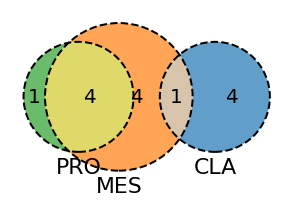

<Figure size 144x288 with 0 Axes>

In [369]:

geneRanked = PAGER.pagRankedGene(select_id)
def candidate_df(m_genes,geneRanked):
    deg_results = m_genes
    df_member=deg_results[['symbol','logFC','p-value']].merge(
        geneRanked[['GENE_SYM','DESCRIPTION','RP_SCORE']],left_on="symbol",right_on="GENE_SYM")
    df_member = df_member.sort_values('RP_SCORE',ascending=False)
    df_member = df_member.fillna(0)
    df_member.RP_SCORE = df_member.RP_SCORE.astype('double')
    df_member.RP_SCORE = round(df_member.RP_SCORE, 1)
    df_member.logFC = round(df_member.logFC, 2)
    df_member = df_member[['GENE_SYM','DESCRIPTION','RP_SCORE','logFC','p-value']]
    df_member.columns = ['Gene symbol','Description','Rp score','logFC','P-value']   
    return df_member.reset_index(drop=True)
### gene count ###
m_df_member = candidate_df(m_genes,geneRanked)
p_df_member = candidate_df(p_genes,geneRanked)
c_df_member = candidate_df(c_genes,geneRanked)
m_df_member['Type'] = 'mesenchymal'
p_df_member['Type'] = 'proneural'
c_df_member['Type'] = 'classical'
all_df_member = pd.DataFrame()
all_df_member = all_df_member.append(m_df_member)
all_df_member = all_df_member.append(p_df_member)
all_df_member = all_df_member.append(c_df_member)

aggretype=all_df_member[['Gene symbol','Type']].groupby('Gene symbol').agg(lambda x : '|'.join(set(x))).reset_index()
count_venn=aggretype.groupby(['Type']).count()
count_venn = count_venn.reset_index()
count_venn.index = count_venn['Type'].values
count_venn
# import module
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

def detect(count,name):
    try:
        return(count.loc[name,'Gene symbol'])
    except:
        return 0
sets = (
    detect(count_venn,'mesenchymal'), 
    detect(count_venn,'proneural'),
    detect(count_venn,'mesenchymal|proneural'), 
    detect(count_venn,'classical'), 
    detect(count_venn,'mesenchymal|classical'), 
    detect(count_venn,'proneural|classical') ,
    detect(count_venn,'mesenchymal|classical|proneural') 
)
# depict venn diagram
v_test1 = venn3(subsets=sets, 
      set_labels=('MES', 'PRO', 'CLA'), 
      set_colors=[color_discrete_map2[sample] for sample in ['Mesenchymal', 'Proneural', 'Classical']], 
      alpha=0.7
     )
  
# outline of circle line style and width
venn3_circles(subsets=sets,
              linestyle="dashed", linewidth=2)
for t in v_test1.set_labels: t.set_fontsize(22)
for t in v_test1.subset_labels: 
    if t != None: t.set_fontsize(20)   
# title of the venn diagram
#plt.title("Venn diagram of genes shared in the subcohort gene panel")
plt.figure(figsize=(2, 4))
plt.show()

In [370]:
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from matplotlib.ticker import FixedLocator
import matplotlib
# Data set
#df_member = m_df_member
#sel_mtx_final = Msel_mtx_final

def heatmapplot(df_member,sel_mtx_final,mtx_type_pd, cellSizePixels=50,**kwargs):
    mtx_type_pd.index = mtx_type_pd.SAMPLE_ID.values
    submatrix = mtx_type_pd.loc[sel_mtx_final['SAMPLE_ID'],df_member['Gene symbol']]
    phenotype = mtx_type_pd.loc[sel_mtx_final['SAMPLE_ID'],:]['DSS.time']
    df = submatrix.T
     
    # load the color scale using the cm
    top = cm.get_cmap('Blues_r', 56)
    bottom = cm.get_cmap('Reds', 56)
    newcolors = np.vstack((top(np.linspace(0, 1, 56)),([[0,0,0,0.1]]),
                   bottom(np.linspace(0, 1, 56))))
    newcmp = ListedColormap(newcolors, name='RedBlue')
    # set the balance point of the expression to 0
    f_max = max(np.max(df))/3
    f_min = min(np.min(df))/3
    # the bound detections
    if(abs(f_max)>abs(f_min)):
        Bound=abs(f_max)
    else:
        Bound=abs(f_min)
        
    ### continuous color
    # option 1:
    bottom = cm.get_cmap('Greens', 1000)
    newcolors2 = np.vstack((
                   bottom(np.linspace(0, 1, 1000))
    ))
    newcmp2 = ListedColormap(newcolors2, name='Greens')
     
    # option 2:
    bounds = [0,400,800,1000]
    colors = ["r", "b", "g"]
    cmap = ListedColormap(colors)
    norm = matplotlib.colors.BoundaryNorm(bounds, len(colors))    
    attr = mtx_type_pd.loc[sel_mtx_final['SAMPLE_ID'],:]['DSS.time']
    attr_int = attr.astype('int')
    col_colors = attr_int.map(newcmp2)
    
    ### Prepare a vector of color mapped to the 'Novel' column
    ### discrete color
    if 'Novel' in kwargs.keys() :
        my_palette = dict(zip(df_member['Novel'].unique(), ["b","white"]))
        row_colors = df_member['Novel'].map(my_palette)  
        row_colors.index = df_member['Gene symbol'].values
    #print(row_colors)
    #print(col_colors)
    #fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,15), gridspec_kw={'height_ratios':[5, 1]})
    
    # ref: https://stackoverflow.com/questions/52806878/seaborn-clustermap-fixed-cell-size
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams['figure.dpi']
    marginWidth = matplotlib.rcParams['figure.subplot.right']-matplotlib.rcParams['figure.subplot.left']
    marginHeight = matplotlib.rcParams['figure.subplot.top']-matplotlib.rcParams['figure.subplot.bottom']
    Ny,Nx = df.shape
    figWidth = (Nx*cellSizePixels/dpi)/0.8/marginWidth
    figHeigh = (Ny*cellSizePixels/dpi)/0.8/marginHeight
    
    # plot
    try:
        g=sns.clustermap(
            df, metric="correlation", method="single", cmap=newcmp, standard_scale=1, yticklabels=True,
            vmax=Bound,vmin=-Bound,
            #col_cluster=False,
            square = True,
            col_colors=col_colors,
            row_colors =row_colors
        )
    except:
        g=sns.clustermap(
            df, metric="correlation", method="single", cmap=newcmp, standard_scale=1, yticklabels=True,
            vmax=Bound,vmin=-Bound,
            square = True,
            #col_cluster=False,
            #row_cluster=False,   
            col_colors=col_colors,
        
        )
    hm = g.ax_heatmap.get_position()
   
    #plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=annotationSize)
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), 
                                 #fontsize = 15
                                )
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), 
                                 #fontsize = 15
                                )
      
    #bottom, top = g.ax_heatmap.get_ylim()
    #g.ax_heatmap.set_ylim(bottom + 0.5, top - 0.5)  
    plt.rcParams["axes.grid"] = False
    #g.fig.subplots_adjust(right=0.1)
    
    ## calculate the size of the heatmap axes
    #axWidth = (Nx*cellSizePixels)/(figWidth*dpi)
    #axHeight = (Ny*cellSizePixels)/(figHeigh*dpi)
    ## resize heatmap
    #ax_heatmap_orig_pos = g.ax_heatmap.get_position()
    #g.ax_heatmap.set_position([ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, 
    #                              axWidth, axHeight])
    ## resize dendrograms to match
    #ax_row_orig_pos = g.ax_row_dendrogram.get_position()
    #g.ax_row_dendrogram.set_position([ax_row_orig_pos.x0, ax_row_orig_pos.y0, 
    #                                     ax_row_orig_pos.width, axHeight])
    #ax_col_orig_pos = g.ax_col_dendrogram.get_position()
    #g.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight,
    #                                     axWidth, ax_col_orig_pos.height])
    
    plt.show()

'Glioblastoma signaling pathways'

/home/zongliang/.conda/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'

/home/zongliang/.conda/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'

/home/zongliang/.conda/envs/py38/lib/python3.8/site-packages/seaborn/matrix.py:1215: UserWarning:

``square=True`` ignored in clustermap



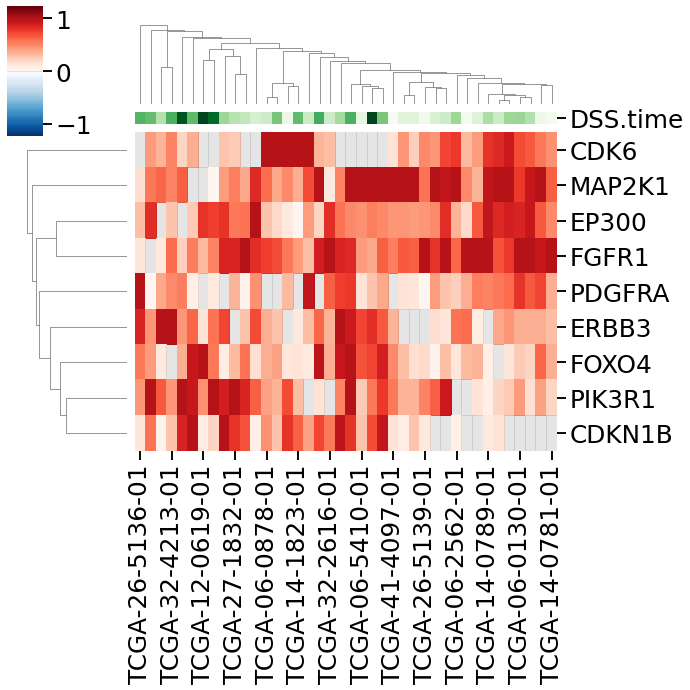

/home/zongliang/.conda/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'

/home/zongliang/.conda/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'

/home/zongliang/.conda/envs/py38/lib/python3.8/site-packages/seaborn/matrix.py:1215: UserWarning:

``square=True`` ignored in clustermap



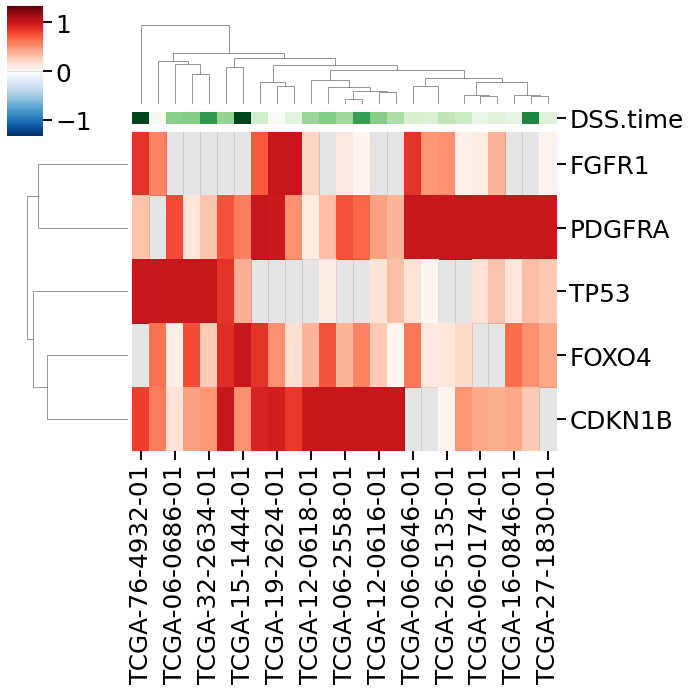

/home/zongliang/.conda/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'

/home/zongliang/.conda/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'

/home/zongliang/.conda/envs/py38/lib/python3.8/site-packages/seaborn/matrix.py:1215: UserWarning:

``square=True`` ignored in clustermap



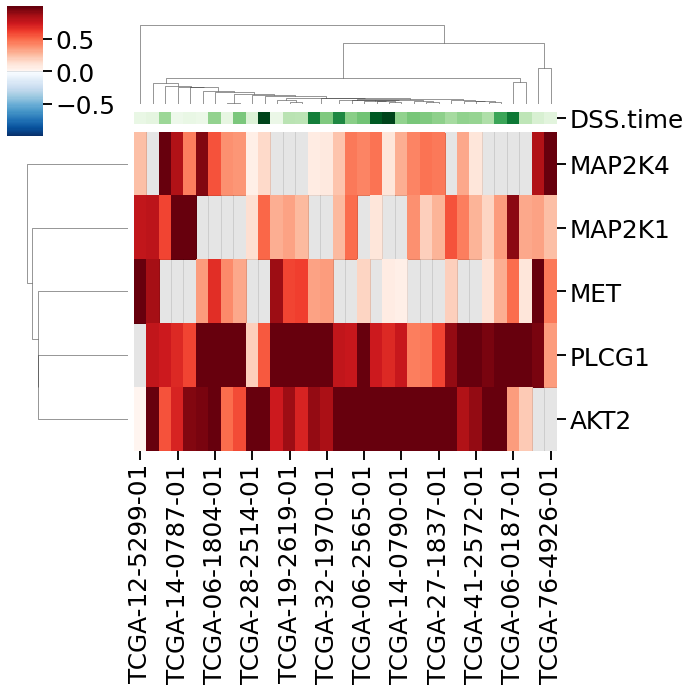

In [373]:
pathwayname
sns.set_context("talk", font_scale=1.5)
heatmapplot(m_df_member,Msel_mtx_final,mtx_type_pd, cellSizePixels=50)
heatmapplot(p_df_member,Psel_mtx_final,mtx_type_pd, cellSizePixels=5)
heatmapplot(c_df_member,Csel_mtx_final,mtx_type_pd, cellSizePixels=5)

In [288]:
m_df_member
Msel_mtx_final
mtx_type_pd

,Gene symbol,Description,Rp score,logFC,P-value,Type
0,NFKB1,nuclear factor kappa B subunit 1,94.1,-0.61,0.00900,mesenchymal
1,BCL2,BCL2 apoptosis regulator,71.9,0.76,0.00650,mesenchymal
2,PTGS2,prostaglandin-endoperoxide synthase 2,54.3,-0.68,0.04300,mesenchymal
3,PDGFRA,platelet derived growth factor receptor alpha,53.8,-0.62,0.00740,mesenchymal
4,CDKN1B,cyclin dependent kinase inhibitor 1B,53.3,1.19,0.00012,mesenchymal
...,...,...,...,...,...,...
12,MLH1,mutL homolog 1,16.0,0.60,0.03400,mesenchymal
13,PIK3R1,phosphoinositide-3-kinase regulatory subunit 1,148.3,0.72,0.00710,mesenchymal
14,MYC,"MYC proto-oncogene, bHLH transcription factor",107.9,-0.88,0.00280,mesenchymal
15,EP300,E1A binding protein p300,100.7,-0.68,0.01600,mesenchymal


,SAMPLE_ID,Gene_Expression_Subtype,DSS.time,vital_status,pathwayScore,status
1,TCGA-02-0055-01,Mesenchymal,76.0,Dead,2.9182,1
3,TCGA-02-2486-01,Mesenchymal,618.0,Dead,-7.1570,1
5,TCGA-06-0130-01,Mesenchymal,394.0,Dead,4.3271,1
6,TCGA-06-0141-01,Mesenchymal,313.0,Dead,-2.9074,1
9,TCGA-06-0168-01,Mesenchymal,598.0,Dead,-3.1056,1
...,...,...,...,...,...,...
100,TCGA-32-2616-01,Mesenchymal,224.0,Dead,-7.6189,1
101,TCGA-32-2632-01,Mesenchymal,269.0,Dead,-0.2631,1
104,TCGA-32-4213-01,Mesenchymal,604.0,Alive,-3.1817,0
108,TCGA-41-3915-01,Mesenchymal,360.0,Dead,4.7385,1


,SAMPLE_ID,Gene_Expression_Subtype,vital_status,DSS.time,ABCA6,...,ZNF384,ZNF521,ZNF560,ZNF695,ZRSR2
TCGA-02-0047-01,TCGA-02-0047-01,Proneural,Dead,448.0,0.6853,...,-1.0165,-0.5599,0.5847,0.5233,-1.1243
TCGA-02-0055-01,TCGA-02-0055-01,Mesenchymal,Dead,76.0,0.8023,...,-1.1584,-0.7806,0.7610,1.1806,1.4716
TCGA-02-2485-01,TCGA-02-2485-01,Classical,Alive,470.0,-0.5379,...,1.0085,0.7577,-0.1330,-1.1050,-0.2762
TCGA-02-2486-01,TCGA-02-2486-01,Mesenchymal,Dead,618.0,0.6180,...,-0.9980,-1.1557,-1.1161,-0.7956,1.1523
TCGA-06-0125-01,TCGA-06-0125-01,Classical,Dead,1448.0,-0.0689,...,0.7755,0.7257,-0.0062,-0.7387,1.3021
...,...,...,...,...,...,...,...,...,...,...,...
TCGA-76-4925-01,TCGA-76-4925-01,Proneural,Dead,146.0,-1.2294,...,0.6245,0.5288,-0.7286,-0.8318,-0.0458
TCGA-76-4926-01,TCGA-76-4926-01,Classical,Dead,138.0,2.0147,...,-0.6271,1.1673,-0.5649,0.7975,-0.3860
TCGA-76-4928-01,TCGA-76-4928-01,Classical,Dead,94.0,2.2640,...,-0.3066,-0.7741,-0.3092,-0.9639,1.3553
TCGA-76-4931-01,TCGA-76-4931-01,Classical,Dead,279.0,-1.2790,...,1.1987,0.2250,0.5839,-0.9266,1.1906
